# 🤪 Variational Autoencoders - CelebA Faces

In this notebook, we'll walk through the steps required to train your own variational autoencoder on the CelebA faces dataset

In [61]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)

from scipy.stats import norm
import pandas as pd

from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces
from utils import display

import warnings
warnings.filterwarnings('ignore')

In [62]:
print(tf.__version__)
print(keras.__version__)

2.17.0
3.5.0


In [2]:
def display_img(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

## 0. Parameters <a name="parameters"></a>

In [29]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 128
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 5
BETA = 2000
LOAD_MODEL = False

## 1. Prepare the data <a name="prepare"></a>

In [5]:
# Load the data
#грузим изображения и сжимаем их до 32х32 с помощью интерполяции пикселов
#данные в память будут грузится только при необходимости, например, во время обучения
train_data = utils.image_dataset_from_directory(
    "data/img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files.


In [6]:
#нормируем изображения
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img

train = train_data.map(lambda x: preprocess(x))

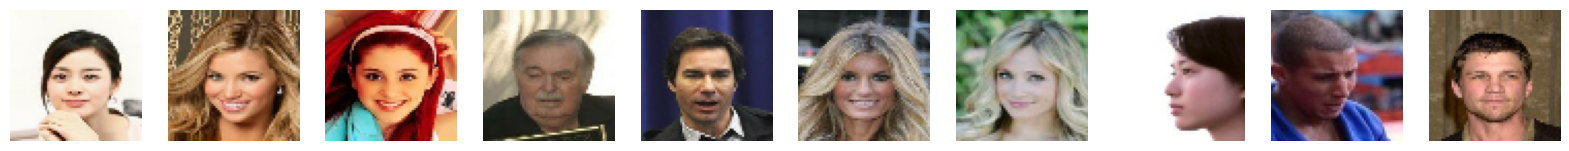

In [7]:
#берет батч примеров
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()

train_sample = sample_batch(train)

# Show some faces from the training set
display_img(train_sample, cmap=None)

## 2. Build the variational autoencoder <a name="build"></a>

In [8]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      3,584 │ encoder_input[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │    147,584 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 128) │    147,584 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 128) │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 4, 4, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 200)       │    409,800 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 200)       │    409,800 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 200)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,267,984 (4.84 MB)

 Trainable params: 1,266,960 (4.83 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [10]:
# Decoder
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │       411,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 3)      │         3,459 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,015,683 (3.87 MB)

 Trainable params: 1,010,563 (3.85 MB)

 Non-trainable params: 5,120 (20.00 KB)

In [24]:
#функции потерь для кодировщика и декодировщика
#в tf 2.17 объявлять функции потерь стоит отдельно
l1 = losses.MeanSquaredError()
l2 = losses.MeanSquaredError()

In [30]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                BETA * l1(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * l2(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [31]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

## 3. Train the variational autoencoder <a name="train"></a>

In [32]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [33]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

#сохраняем пример генерации изображения в конце каждой эпохи
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("./output/generated_img_%03d_%d.png" % (epoch, i))

In [ ]:
# Load old weights if required
if LOAD_MODEL:
    vae.load_weights("./models/vae")
    tmp = vae.predict(train.take(1))

In [34]:
vae.fit(
    train,
    epochs=EPOCHS
    ,callbacks=[model_checkpoint_callback,
                tensorboard_callback,
                ImageGenerator(num_img=1, latent_dim=Z_DIM),
                ],
        )

Epoch 1/5
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 4297s 678ms/step - kl_loss: 15.4708 - loss: 83.6913 - reconstruction_loss: 68.2205
Epoch 2/5
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 4917s 777ms/step - kl_loss: 17.6697 - loss: 65.1686 - reconstruction_loss: 47.4989
Epoch 3/5
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 4639s 733ms/step - kl_loss: 17.9249 - loss: 64.0052 - reconstruction_loss: 46.0802
Epoch 4/5
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 4263s 673ms/step - kl_loss: 18.0404 - loss: 63.4664 - reconstruction_loss: 45.4261
Epoch 5/5
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 4348s 687ms/step - kl_loss: 18.1126 - loss: 63.1565 - reconstruction_loss: 45.0439


In [36]:
# Save the final models
vae.save("./models/vae.keras")
encoder.save("./models/encoder.keras")
decoder.save("./models/decoder.keras")

## 3. Reconstruct using the variational autoencoder <a name="reconstruct"></a>

In [37]:
# Select a subset of the test set
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Example real faces


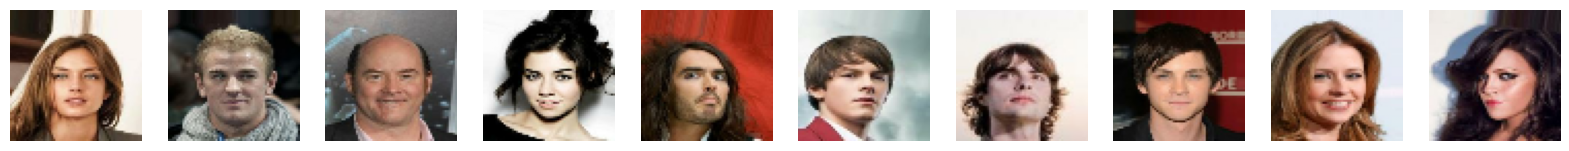

Reconstructions


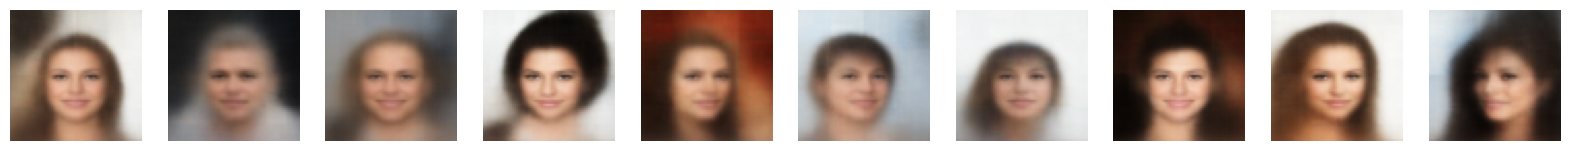

In [38]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real faces")
display_img(example_images)
print("Reconstructions")
display_img(reconstructions)

## 4. Latent space distribution

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


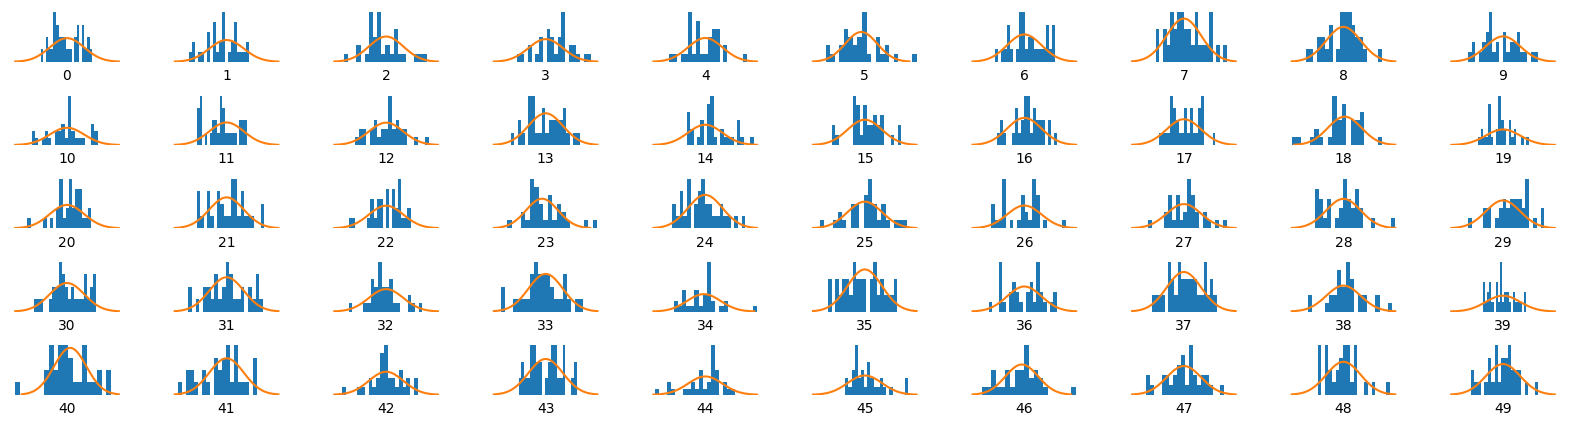

In [39]:
#пример распределений закодированных изображений
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

## 5. Generate new faces <a name="decode"></a>

In [40]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [41]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step


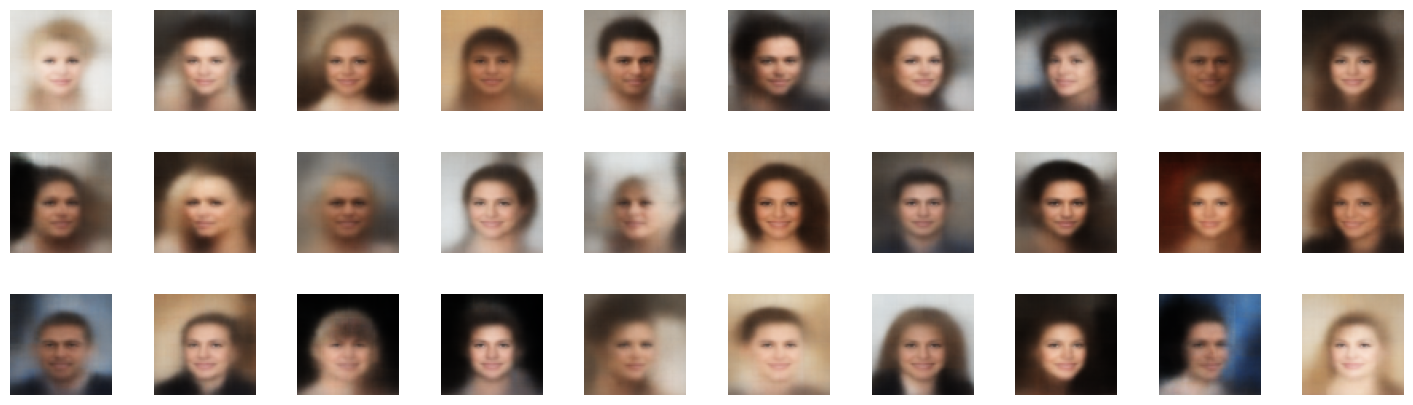

In [42]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])

## 6. Manipulate the images <a name="manipulate"></a>

In [44]:
#датасет с разметкой атрибутов
attributes = pd.read_csv("data/img_align_celeba/list_attr_celeba.csv")
print(attributes.columns)
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [54]:
#загружаем изображения с нужным атрибутом (блондины)
LABEL = "Blond_Hair"  # <- Set this label
labelled_test = utils.image_dataset_from_directory(
    "data/img_align_celeba/img_align_celeba/",
    labels=attributes[LABEL].tolist(),
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)

labelled = labelled_test.map(lambda x, y: (preprocess(x), y))

Found 202599 files belonging to 2 classes.
Using 40519 files for validation.


In [55]:
#берем средние значение векторов с нужным атрибутом 
#вычитаем среднее значениеи векторов без него
#получим вектор, указывающий в направлении атрибута
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM, LABEL)

label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
22    : 2.977    : 1.475    : 3.466    : 3.466
44    : 2.074    : 0.939    : 2.642    : -0.824
65    : 1.086    : 0.552    : 2.276    : -0.366
87    : 0.779    : 0.396    : 2.155    : -0.12
110    : 0.697    : 0.296    : 2.017    : -0.139
128    : 0.511    : 0.27    : 1.908    : -0.109
150    : 0.43    : 0.203    : 1.863    : -0.045
171    : 0.378    : 0.172    : 1.805    : -0.058
197    : 0.362    : 0.159    : 1.765    : -0.04
218    : 0.318    : 0.143    : 1.725    : -0.04
241    : 0.281    : 0.122    : 1.708    : -0.017
260    : 0.241    : 0.12    : 1.67    : -0.038
282    : 0.25    : 0.11    : 1.679    : 0.008
302    : 0.21    : 0.103    : 1.662    : -0.017
317    : 0.166    : 0.089    : 1.653    : -0.009
337    : 0.191    : 0.085    : 1.634    : -0.019
356    : 0.171    : 0.082    : 1.594    : -0.04
377    : 0.188    : 0.079    : 1.58    : -0.014
395    : 0.145    : 0.079    : 1.554    : -0.026
415    : 0.167   

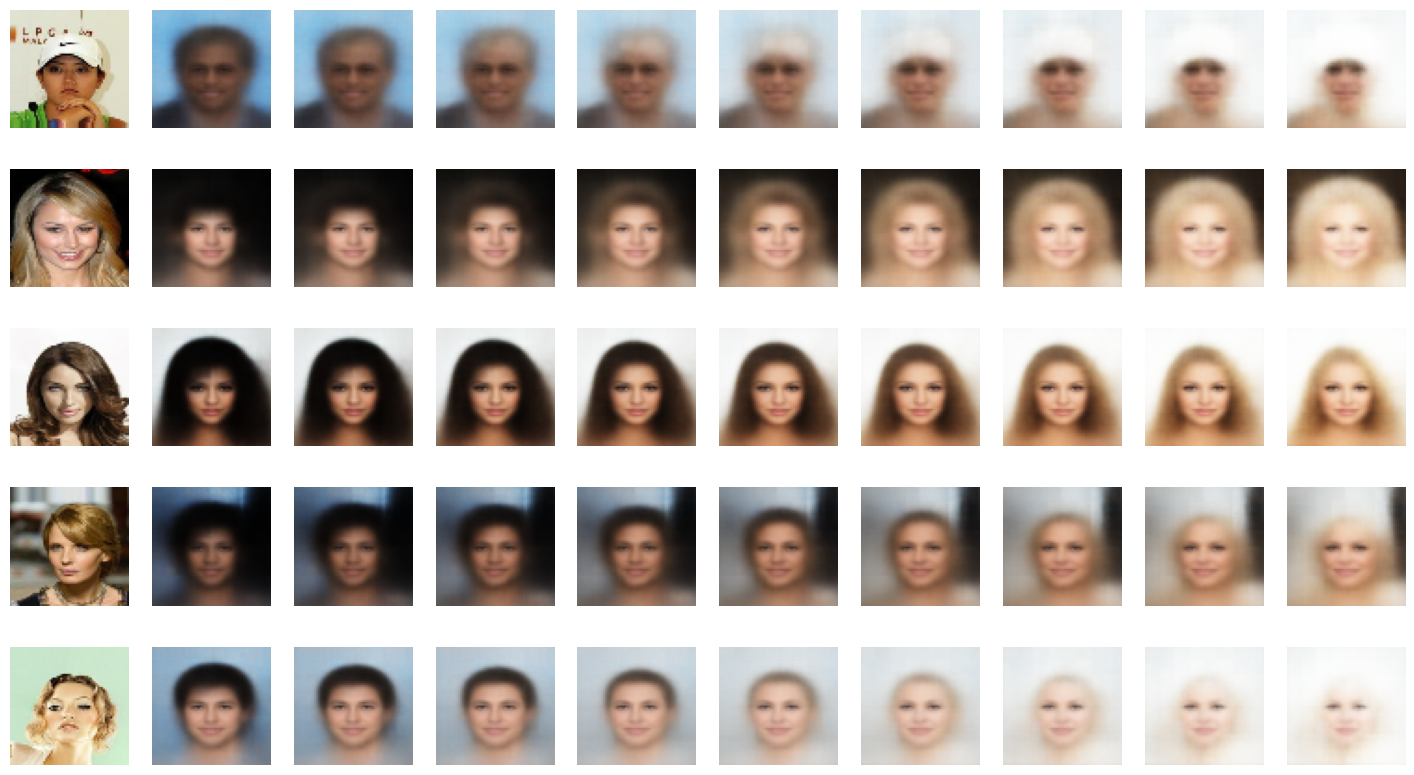

In [59]:
#прибавляем к исходному изображение вектор с атрибутом с всё большим коэффициентом
#смотрим как меняется изображение
add_vector_to_images(labelled, vae, attribute_vec)

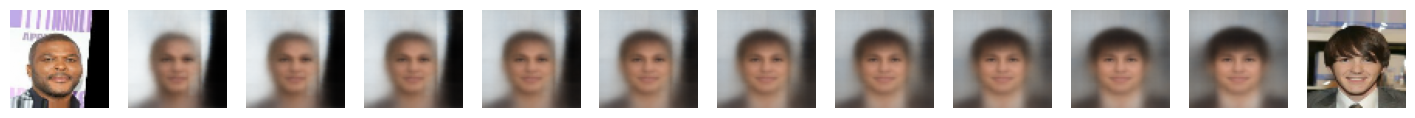

In [60]:
#двигаясь в скрытом пространстве от одного вектора к другому
#можно создать переход от одного изображения к другому
morph_faces(labelled, vae)